### **Forest Fire Classification Model**

**Sumber Data:** NASA (https://modis.gsfc.nasa.gov)

**Periode:** 2000 s/d 2022

Dari semua data modis (Indonesia) 2000-2022 yang di unduh, kemudian dikombinasikan menjadi 1 file dan disimpan menjadi data baru bernama `modis_combined.csv`.

In [6]:
import pandas as pd
import glob

file_paths = glob.glob('data/modis_*.csv')

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs)

combined_df.to_csv('data/modis_combined.csv', index=False)
combined_df.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
38069,2.7888,125.3980,306.0,2.4,1.5,2018-12-30,1648,Aqua,MODIS,40,6.03,276.0,30.5,N,1
38070,-3.9067,122.4191,315.3,1.0,1.0,2018-12-31,215,Terra,MODIS,63,6.03,277.9,10.4,D,2
38071,-1.4970,121.5413,305.0,1.7,1.3,2018-12-31,510,Aqua,MODIS,55,6.03,281.1,9.5,D,0
38072,-4.6117,104.9702,310.5,1.2,1.1,2018-12-31,648,Aqua,MODIS,63,6.03,279.9,8.1,D,0
38073,0.6136,117.4390,303.9,1.0,1.0,2018-12-31,1436,Terra,MODIS,57,6.03,283.1,5.2,N,0


Berikut penjelasan tiap kolomnya:

| No | Atribut      | Keterangan |
|:---|:-------------|:-----------|
| 1  | `latitude`   | Garis lintang dari piksel kebakaran yang terdeteksi oleh satelit (derajat) |
| 2  | `longitude`   | Garis bujur dari piksel kebakaran yang terdeteksi oleh satelit (derajat) |
| 3  | `brightness`   | Suhu kecerahan piksel kebakaran (dalam K) |
| 4  | `scan`   | Luas piksel MODIS di permukaan Bumi (sepanjang pemindaian: ΔS) |
| 5  | `track`   | Luas piksel MODIS di permukaan Bumi (sepanjang jejak: ΔT) |
| 6  | `acq_time`   | Waktu terdeteksinya kebakaran |
| 7  | `satellite`   | Satelit yang digunakan untuk mendeteksi kebakaran. Either Terra (T) atau Aqua (A) |
| 8  | `instrument`   | MODIS |
| 9  | `confidence`   | Tingkat kepercayaan deteksi (rentang 0-100) |
| 10 | `bright_t31`   | Suhu kecerahan Band 31 piksel (dalam K) |
| 11 | `frp`   | Daya radiasi kebakaran (dalam MW - megawatt) |
| 12 | `daynight`   | Terdeteksi pada siang hari atau malam hari. Either Day (D) atau Night (N) |
| 13 | `type`   | Jenis titik panas yang disimpulkan: <br/>- 0 = kebakaran vegetasi yang diduga<br/>- 1 = gunung berapi aktif<br/>- 2 = sumber daratan statis lainnya<br/>- 3 = lepas pantai |

Selanjutnya coba periksa titik koordinatnya melalui GIS (Spasial)

In [ ]:
import pandas as pd
import folium

map = folium.Map(location=[-0.5, 117.5], zoom_start=8)

for index, row in combined_df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    brightness = row['brightness']
    marker = folium.Marker([lat, lon], popup=f"Brightness: {brightness}")
    marker.add_to(map)

map.save('map.html')
map

In [60]:
df = combined_df

print(df['satellite'].value_counts())
print(df['daynight'].value_counts())
print(df['type'].value_counts())

satellite
Aqua     961728
Terra    478138
Name: count, dtype: int64
daynight
D    1116039
N     323827
Name: count, dtype: int64
type
0    1361340
2      68931
1       9123
3        472
Name: count, dtype: int64


Seperti yang dilihat, ada selisih nilai yang cukup besar pada kolom `type` untuk indeks ke-3. Untuk itu, kami akan menghapusnya.

In [61]:
df = df.loc[df['type'] != 3].reset_index(drop=True)

Handling categorical values
- Since we have 2 values (Terra and Aqua) for satellite, we will be using a binary encoder

In [ ]:
# %pip install category_encoders

In [62]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['satellite'])
df = encoder.fit_transform(df)
encoder = ce.BinaryEncoder(cols=['daynight'])
df = encoder.fit_transform(df)

In [63]:
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite_0,satellite_1,instrument,confidence,version,bright_t31,frp,daynight_0,daynight_1,type
0,-4.0530,136.6032,313.3,1.0,1.0,2019-01-01,119,0,1,MODIS,72,6.03,292.2,9.1,0,1,0
1,-4.0591,135.7771,305.3,1.0,1.0,2019-01-01,119,0,1,MODIS,42,6.03,287.5,5.0,0,1,0
2,-4.0605,135.7863,326.1,1.0,1.0,2019-01-01,119,0,1,MODIS,83,6.03,287.2,24.1,0,1,0
3,2.7885,125.4074,313.8,1.2,1.1,2019-01-02,201,0,1,MODIS,59,6.03,282.7,12.3,0,1,1
4,2.7788,125.4072,329.2,1.2,1.1,2019-01-02,201,0,1,MODIS,82,6.03,284.5,30.8,0,1,1


- Here satellite_0 is for Aqua while satellite_1 is for Terra
- And daynight_0 is for Day while daynight_1 is for Night
- Hence we can remove one of them

In [64]:
df = df.drop(['acq_date', 'instrument', 'satellite_1','daynight_1'], axis=1)

Handling the time column acq_time
- Since it's in the format HHMM, we will only extract the hours part of the time, minutes won't be relevant for our model.
- using floor division we removed last 2 digits that represented the minutes

In [65]:
df['acq_time'] = df['acq_time']//100 
df.head()

,latitude,longitude,brightness,scan,track,acq_time,satellite_0,confidence,version,bright_t31,frp,daynight_0,type
0,-4.0530,136.6032,313.3,1.0,1.0,1,0,72,6.03,292.2,9.1,0,0
1,-4.0591,135.7771,305.3,1.0,1.0,1,0,42,6.03,287.5,5.0,0,0
2,-4.0605,135.7863,326.1,1.0,1.0,1,0,83,6.03,287.2,24.1,0,0
3,2.7885,125.4074,313.8,1.2,1.1,2,0,59,6.03,282.7,12.3,0,1
4,2.7788,125.4072,329.2,1.2,1.1,2,0,82,6.03,284.5,30.8,0,1


Feature Selection and finding the correlation
- We are using stratified shuffle split since our dataset contains unbalanced classes for the type column.

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit
target='type'

feature_cols = [x for x in df.columns if x != target]

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(df[feature_cols], df[target]))

# Create the data sets
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target]
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target]

- Now that we have split the model, we will start with the feature selection

<Axes: >

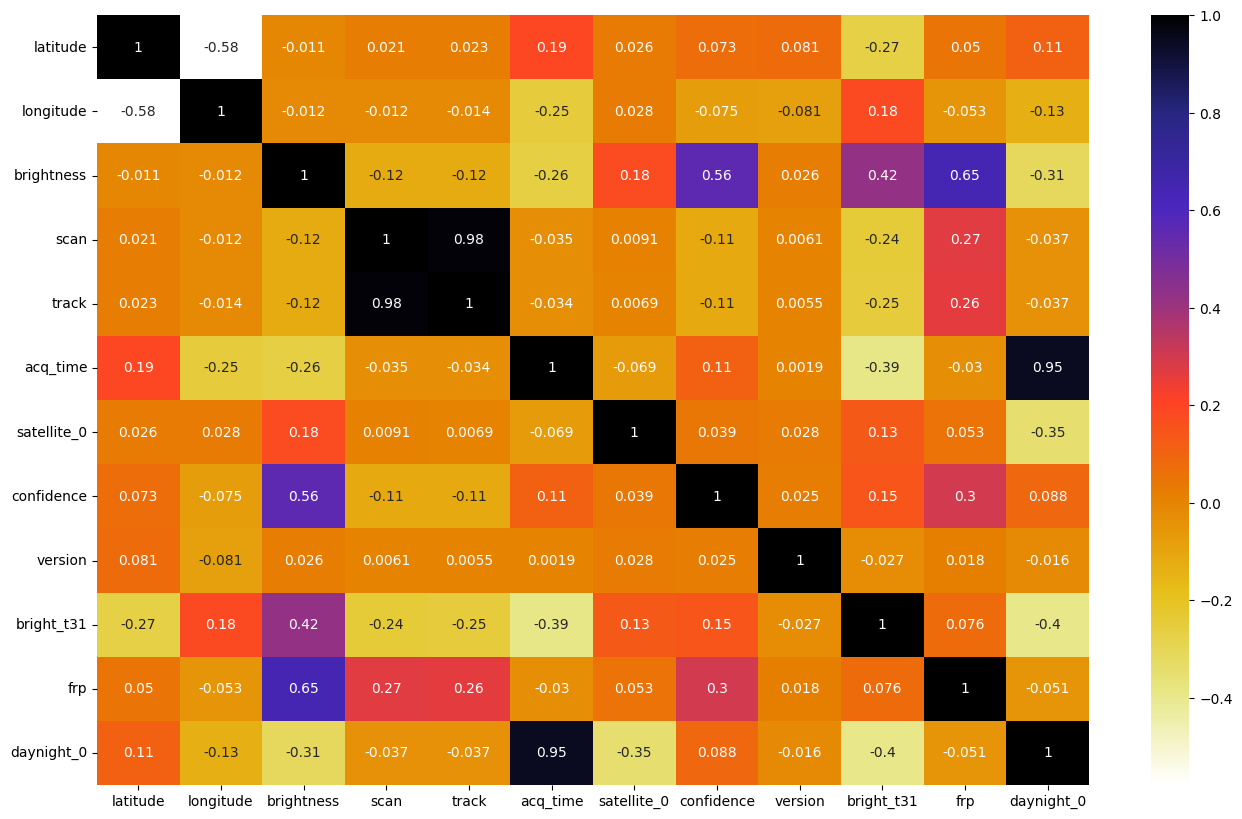

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
cor=X_train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

We will define a function to identify the highly correlated features to remove them

In [68]:
def correlation(dataset, threshold):
     col_corr = set() # Set of all the names of correlated columns
     corr_matrix = dataset.corr()
     for i in range(len(corr_matrix.columns)):
         for j in range(i):
             if (corr_matrix.iloc[i,j])>threshold: # we are interested in absolute coeff value
                 colname= corr_matrix.columns[i] # getting the name of column
                 col_corr.add(colname) 
     return col_corr

In [69]:
features= correlation(X_train,0.9)
print(set(features))

{'daynight_0', 'track'}


We can now drop the features track and daynight_0

In [70]:
X_train=X_train.drop(['track','daynight_0'],axis=1)

Applying the same to test data

In [71]:
X_test=X_test.drop(['track','daynight_0'],axis=1)

Applying Machine Learning Models
- We will be applying 3 models and comparing it with each other:
    - Logistic Regression
    - K Nearest Neighbours
    - XG Boost

Logistic Regression

We are keeping an l2 regularization since it has comparatively lesser computational complexity

In [72]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l2').fit(X_train, y_train)

Plotting the confusion matrix

In [73]:
predictions=lr.predict(X_test)

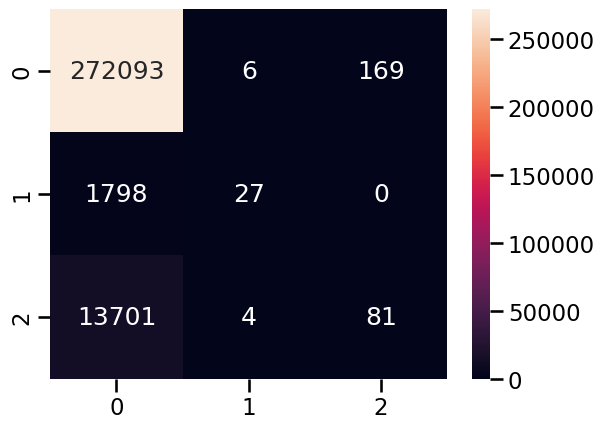

In [74]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
sns.set_context('talk')
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm, annot=True, fmt='d')

The confusion matrix for logistic regression indicates that all the type 0s are predicted correctly, none of them are predicted as 1, while a lot of type 2s (depicted as 1 in the confusion matrix) are predicted as 0.

In [76]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions), 2))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    272268
           1       0.73      0.01      0.03      1825
           2       0.32      0.01      0.01     13786

    accuracy                           0.95    287879
   macro avg       0.67      0.34      0.34    287879
weighted avg       0.91      0.95      0.92    287879

Accuracy score:  0.95


Therefore with logistic regression we get an accuracy of 95%

K Nearest Neighbour

In [77]:
from sklearn.neighbors import KNeighborsClassifier

Checking the accuracy for different values of K to find the best one

In [78]:
accuracy_rate=[]

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score=round(accuracy_score(y_test, y_pred), 2)
    accuracy_rate.append(score.mean())

Text(0, 0.5, 'Accuracy')

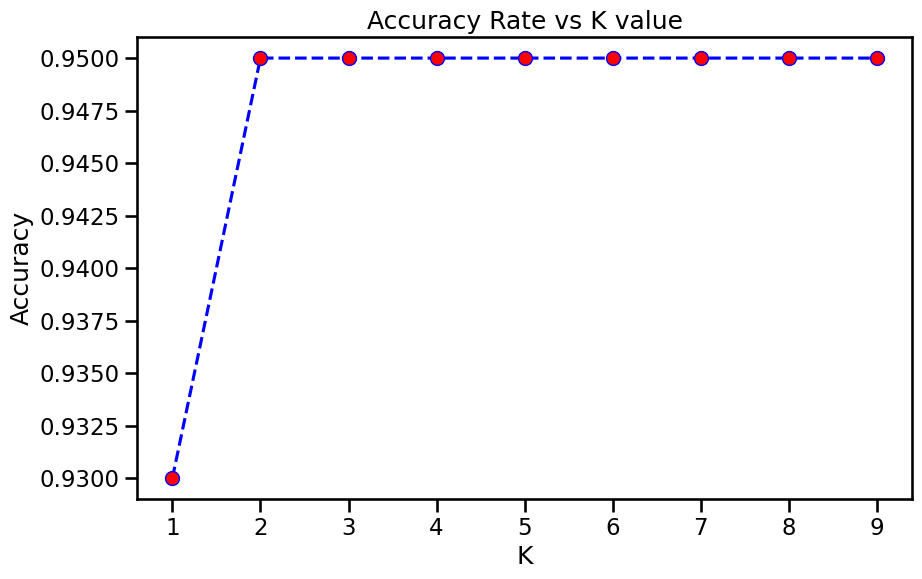

In [79]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),accuracy_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Accuracy Rate vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy')

As shown in the graph. K=2 gives us the best accuracy.

In [80]:
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    272268
           1       0.58      0.42      0.48      1825
           2       0.56      0.17      0.26     13786

    accuracy                           0.95    287879
   macro avg       0.70      0.53      0.57    287879
weighted avg       0.94      0.95      0.94    287879

Accuracy score:  0.95


Plotting the confusion matrix for KNN

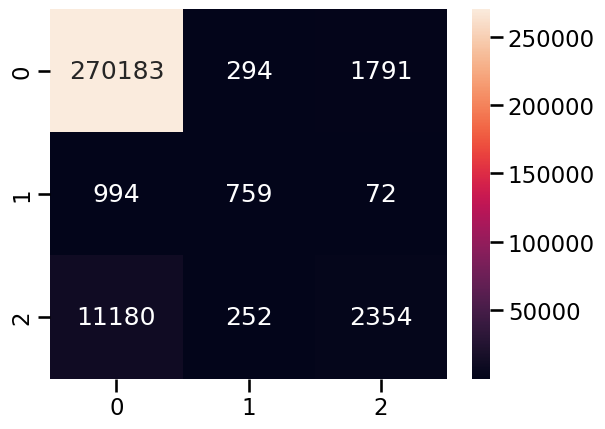

In [81]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

Even though the accuracy for KNN (95%) is higher than that for Logistic Regression (93%), KNN model predicts a fair number of type 0s incorrectly.

XG BOOST

- Using a list of number of trees we will iterate through each and select the one that gives us the least error.

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    error = 1.0 - accuracy_score(y_test, y_pred)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 25 trees


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 50 trees


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 100 trees


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 200 trees


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 400 trees


- Plotting a graph to analyse the error rate for every number of trees.

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

- As shown in the graph, no. of trees=200 gives us the least error

We can also make the use of GridSearchCV library of Sklearn to find the best estimator.

In [ ]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [ ]:
GV_GBC.best_estimator_

In [ ]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

We can get an accuracy of 98% with XGBOOST, higher than the rest of the models.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

Confusion matrix shows least amount values predicted incorrectly.

Conclusion:

- Logistic Regression: 93%
- KNN: 95%
- XGBOOST: 98%

Hence the best Algorithm for the prediction of the type of forest fire detected by MODIS satellite will be XGBOOST